In [ ]:
!pip install HalvingGridSearchCV

ERROR: Could not find a version that satisfies the requirement HalvingGridSearchCV (from versions: none)
ERROR: No matching distribution found for HalvingGridSearchCV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from lightgbm import LGBMClassifier
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import make_multilabel_classification
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
#import catboost
#from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

import copy
import random
import os
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

False

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

''

In [ ]:
# Load files to my drive into a pandas dataframe 
train = pd.read_csv('/content/drive/MyDrive/Competition2/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Competition2/Test.csv')
ss = pd.read_csv('/content/drive/MyDrive/Competition2/SampleSubmission.csv')

In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (108446, 42)
The shape of the test set is: (46477, 41)


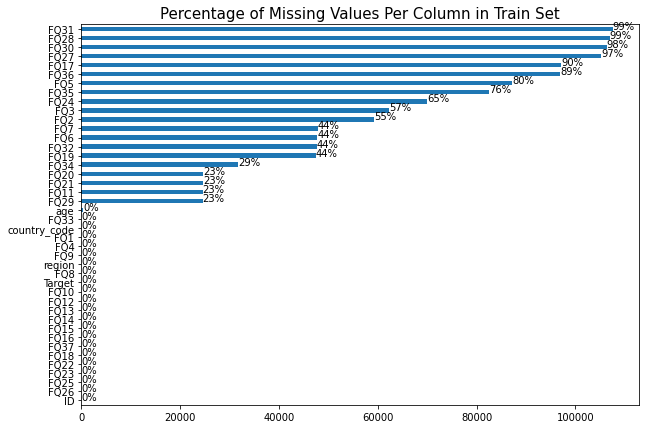

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

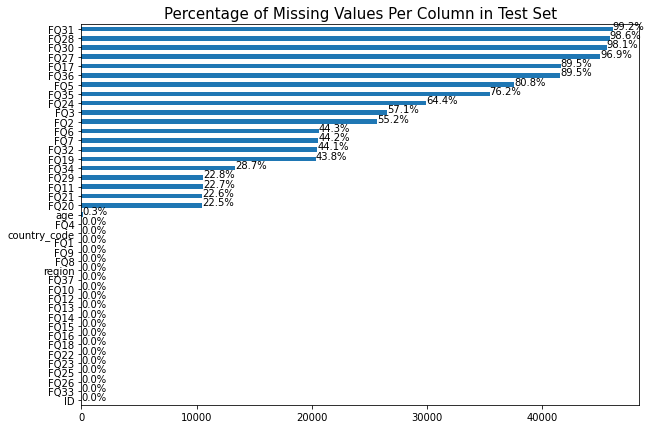

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (154923, 42)


In [ ]:
all_data.columns

Index(['ID', 'country_code', 'region', 'age', 'FQ1', 'FQ2', 'FQ3', 'FQ4',
       'FQ5', 'FQ6', 'FQ7', 'FQ8', 'FQ9', 'FQ10', 'FQ11', 'FQ12', 'FQ13',
       'FQ14', 'FQ15', 'FQ16', 'FQ17', 'FQ18', 'FQ19', 'FQ20', 'FQ21', 'FQ22',
       'FQ23', 'FQ24', 'FQ35', 'FQ36', 'FQ25', 'FQ26', 'FQ27', 'FQ28', 'FQ29',
       'FQ30', 'FQ31', 'FQ32', 'FQ33', 'FQ34', 'FQ37', 'Target'],
      dtype='object')

In [ ]:
# Check the column names and datatypes
all_data['age'].median()

39.0

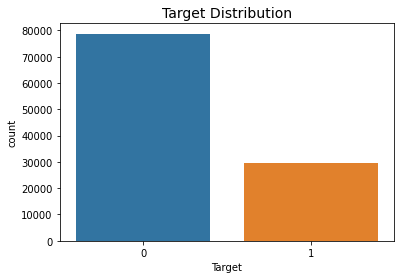

In [ ]:
#show the count values of the target
sns.countplot(train.Target)
plt.title('Target Distribution', fontdict={'size':14});

In [ ]:
#Classify by type: object. 
num_cols = ['country_code', 'region','Target']

#Classify due to median value for integer number. 
num_cols1=['FQ1', 'FQ4',
       'FQ6' ,  'FQ7', 'FQ8', 'FQ9', 'FQ10', 'FQ11', 'FQ12', 'FQ13',
       'FQ14', 'FQ15', 'FQ16', 'FQ20', 'FQ21',
       'FQ23', 'FQ25', 'FQ26', 'FQ29', 'FQ32']
num_cols2=['FQ2', 'FQ3',
       'FQ5',  'FQ17', 'FQ19',
       'FQ24', 'FQ35', 'FQ36', 'FQ27', 'FQ28',
       'FQ30', 'FQ31']
num_cols3=['FQ18', 'FQ22', 'FQ33', 'FQ34', 'FQ37']
num_cols4=['age']
#cat_cols = [col for col in all_data.columns if col not in num_cols+num_cols1+['ID']]

In [ ]:
# Fill in missing values
# For num cols fill in with median value
for col in all_data.columns:
  if col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(0))
  elif col in num_cols1:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(2))
  elif col in num_cols2:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(3))
  elif col in num_cols3:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(1))
  elif col in num_cols4:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(39))
    
# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['Target'])].isna().sum()

FQ1             0
FQ10            0
FQ11            0
FQ12            0
FQ13            0
FQ14            0
FQ15            0
FQ16            0
FQ17            0
FQ18            0
FQ19            0
FQ2             0
FQ20            0
FQ21            0
FQ22            0
FQ23            0
FQ24            0
FQ25            0
FQ26            0
FQ27            0
FQ28            0
FQ29            0
FQ3             0
FQ30            0
FQ31            0
FQ32            0
FQ33            0
FQ34            0
FQ35            0
FQ36            0
FQ37            0
FQ4             0
FQ5             0
FQ6             0
FQ7             0
FQ8             0
FQ9             0
ID              0
age             0
country_code    0
region          0
dtype: int64

In [ ]:
#Created dataframe without ID column
data1= pd.DataFrame(all_data[['country_code', 'region', 'age', 'FQ1', 'FQ2', 'FQ3', 'FQ4',
       'FQ5', 'FQ6', 'FQ7', 'FQ8', 'FQ9', 'FQ10', 'FQ11', 'FQ12', 'FQ13',
       'FQ14', 'FQ15', 'FQ16', 'FQ17', 'FQ18', 'FQ19', 'FQ20', 'FQ21', 'FQ22',
       'FQ23', 'FQ24', 'FQ35', 'FQ36', 'FQ25', 'FQ26', 'FQ27', 'FQ28', 'FQ29',
       'FQ30', 'FQ31', 'FQ32', 'FQ33', 'FQ34', 'FQ37', 'Target']])

In [ ]:
#Encoder the column ID, and save the result in the dataframe
cols=([ 'ID'])

enc = preprocessing.LabelEncoder()
scaler1=enc.fit_transform(all_data[[ 'ID']])
data2= pd.DataFrame(scaler1)

#Combine both dataframe 
all_data=pd.concat([data1,data2], axis=1)
all_data

,country_code,region,age,FQ1,FQ2,FQ3,FQ4,FQ5,FQ6,FQ7,FQ8,FQ9,FQ10,FQ11,FQ12,FQ13,FQ14,FQ15,FQ16,FQ17,FQ18,FQ19,FQ20,FQ21,FQ22,FQ23,FQ24,FQ35,FQ36,FQ25,FQ26,FQ27,FQ28,FQ29,FQ30,FQ31,FQ32,FQ33,FQ34,FQ37,Target,0
0,1,6,35.0,2,3.0,3.0,2,3.0,2.0,1.0,2,1,1,2.0,2,2,2,2,2,3.0,2,4.0,2.0,1.0,1,2,3.0,1.0,3.0,2,2,3.0,3.0,1.0,3.0,3.0,2.0,1.0,1.0,0,0.0,0
1,32,7,70.0,2,3.0,3.0,2,3.0,2.0,1.0,2,2,2,2.0,2,2,2,2,2,3.0,1,3.0,2.0,1.0,1,2,3.0,3.0,3.0,1,1,3.0,3.0,2.0,3.0,3.0,2.0,1.0,2.0,0,0.0,1
2,71,7,22.0,2,1.0,3.0,2,3.0,2.0,1.0,2,2,2,4.0,2,2,1,2,1,3.0,1,3.0,2.0,2.0,1,2,3.0,3.0,3.0,2,1,3.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,1,0.0,3
3,48,3,27.0,1,3.0,3.0,2,3.0,2.0,2.0,2,1,1,2.0,2,2,2,2,2,3.0,1,1.0,1.0,2.0,1,2,3.0,3.0,3.0,2,2,3.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1,0.0,4
4,25,0,79.0,2,3.0,3.0,2,3.0,2.0,2.0,2,2,1,2.0,2,2,2,2,1,3.0,1,3.0,2.0,2.0,1,1,2.0,3.0,1.0,2,2,3.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154918,112,3,38.0,1,1.0,3.0,2,3.0,2.0,2.0,2,2,2,2.0,1,2,2,2,2,1.0,1,1.0,2.0,2.0,2,2,1.0,3.0,1.0,2,2,3.0,3.0,4.0,3.0,3.0,2.0,1.0,1.0,1,0.0,154912
154919,82,2,77.0,2,1.0,1.0,2,3.0,1.0,1.0,1,2,1,2.0,2,2,2,2,1,3.0,3,1.0,2.0,2.0,2,2,3.0,3.0,3.0,2,1,3.0,3.0,2.0,3.0,3.0,2.0,1.0,2.0,1,0.0,154913
154920,93,5,26.0,2,3.0,3.0,2,3.0,1.0,2.0,1,1,2,2.0,2,1,2,2,1,3.0,2,3.0,2.0,2.0,1,4,3.0,3.0,2.0,1,2,3.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1,0.0,154915
154921,6,7,59.0,2,1.0,3.0,2,3.0,1.0,2.0,2,2,2,1.0,2,2,2,2,2,3.0,2,3.0,2.0,2.0,2,2,2.0,3.0,3.0,2,2,3.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1,0.0,154919


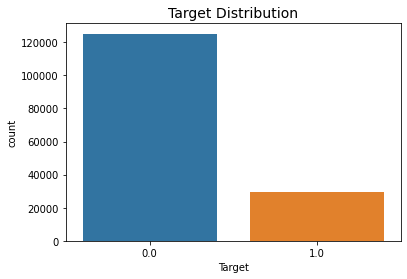

In [ ]:
#show the count values of the target
sns.countplot(all_data.Target)
plt.title('Target Distribution', fontdict={'size':14});

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# for reprocducibility
def seed_all(seed): 
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
seed=0
seed_all(seed)

In [ ]:
seed_all(seed)
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((108446, 42), (46477, 42))

In [ ]:
seed_all(seed)
# Generate two class dataset
# Select main columns to be used in training
main_cols = all_data.columns.difference(['Target'])
X = train_df[main_cols]
y = train_df.Target

# split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0046, random_state=8675309)

In [ ]:
seed_all(seed)
########### Train model #######################
###### we used the ensemble method ############
###############################################
estimators = [('log', LogisticRegression(penalty='l2',dual=False, tol=10, C=0.1, fit_intercept=True, class_weight='balanced', random_state=0, solver='saga', max_iter=100,multi_class='multinomial')) ]
model = StackingClassifier( estimators=estimators, final_estimator= RandomForestClassifier( class_weight='balanced_subsample',n_estimators=39,criterion='entropy',min_samples_split=20,ccp_alpha=0.000008) )

In [ ]:
seed_all(seed)
#### Fit the model ########
model.fit(X_train, y_train)

######### predict probabilities ##############
pred_prob = model.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
seed_all(seed)
# auc scores
auc_score = roc_auc_score(y_test, pred_prob[:,1])

print(auc_score)

0.508381064690027


In [ ]:
seed_all(seed)
print(pred_prob)

[[0.33968393 0.66031607]
 [0.39422032 0.60577968]
 [0.56701649 0.43298351]
 [0.47523484 0.52476516]
 [0.33732579 0.66267421]
 [0.79115105 0.20884895]
 [0.78295518 0.21704482]
 [0.80999807 0.19000193]
 [0.78416994 0.21583006]
 [0.38077762 0.61922238]
 [0.91685949 0.08314051]
 [0.91846204 0.08153796]
 [0.48889087 0.51110913]
 [0.78758527 0.21241473]
 [0.80864923 0.19135077]
 [0.27075537 0.72924463]
 [0.84015976 0.15984024]
 [0.39760783 0.60239217]
 [0.29979085 0.70020915]
 [0.65003356 0.34996644]
 [0.77207056 0.22792944]
 [0.45356698 0.54643302]
 [0.62216787 0.37783213]
 [0.98244271 0.01755729]
 [0.81869094 0.18130906]
 [0.86434634 0.13565366]
 [0.77250567 0.22749433]
 [0.66488535 0.33511465]
 [0.50481512 0.49518488]
 [0.56816253 0.43183747]
 [0.93459378 0.06540622]
 [0.60730755 0.39269245]
 [0.95494823 0.04505177]
 [0.50886849 0.49113151]
 [0.94434957 0.05565043]
 [0.23459016 0.76540984]
 [0.28803759 0.71196241]
 [0.65347879 0.34652121]
 [0.35812586 0.64187414]
 [0.49530241 0.50469759]


In [ ]:
seed_all(seed)
# Make prediction on the test set
test_df = test_df[main_cols]
pred_prob3 = model.predict_proba(test_df)



In [ ]:
seed_all(seed)
# Create a submission file
sub_file = ss.copy()
sub_file.Target = pred_prob3

# Check the distribution of your predictions
#sns.countplot(sub_file.Target);

In [ ]:
#Verify if the test ID are same to submission file
set(test.ID == ss.ID)

{True}

In [ ]:
seed_all(seed)
#Create submission file
print("[INFO] Creating pandas dataframe")
submission_data = {"ID":sub_file['ID'],"Target":pred_prob3[:,1],}
submission_data_frame = pd.DataFrame(submission_data)
submission_data_frame

[INFO] Creating pandas dataframe


,ID,Target
0,ID_000YI58E,0.162223
1,ID_001SP4JF,0.125136
2,ID_001VOF6S,0.125136
3,ID_0030LULG,0.535627
4,ID_0037PZ3R,0.146506
...,...,...
46472,ID_ZZYOTVBJ,0.244885
46473,ID_ZZYSX122,0.244885
46474,ID_ZZYXQDSD,0.226739
46475,ID_ZZZH9SS4,0.226739


In [ ]:
#Save submission dataframe in the drive to CSV
#print("[INFO] Saving Predicition to CSV")
#submission_data_frame.to_csv('/content/drive/MyDrive/Competition2/Sub_130.csv',columns=["ID","Target"], index = False)

[INFO] Saving Predicition to CSV
